### FSEOF analysis


In [1]:
from cobra.io import read_sbml_model, write_sbml_model
from cobra import Reaction, Metabolite
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [2]:
model = read_sbml_model('data/yeastGEM_het.xml')

In [3]:
fseof = FSEOF(model)

In [4]:
fseofresult=fseof.run(target=model.reactions.R07215)

In [5]:
fseofresult

,1,2,3,4,5,6,7,8,9,10
r_0020,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0039,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0040,0.043157,0.051107,0.059055,0.067003,0.074950,0.082898,0.090846,0.098793,0.106741,0.114689
r_0045,0.020012,0.030249,0.040486,0.050723,0.060960,0.071197,0.081434,0.091671,0.101908,0.112145
r_0058,0.020012,0.030249,0.040486,0.050723,0.060960,0.071197,0.081434,0.091671,0.101908,0.112145
...,...,...,...,...,...,...,...,...,...,...
r_4262,0.106074,0.095592,0.085100,0.074609,0.064117,0.053625,0.043134,0.032642,0.022150,0.011659
r_4460,-0.292889,-0.334249,-0.375589,-0.416928,-0.458267,-0.499606,-0.540946,-0.582285,-0.623624,-0.664963
R07498,0.003706,0.007411,0.011117,0.014822,0.018528,0.022233,0.025939,0.029645,0.033350,0.037056
R03353,0.003706,0.007411,0.011117,0.014822,0.018528,0.022233,0.025939,0.029645,0.033350,0.037056


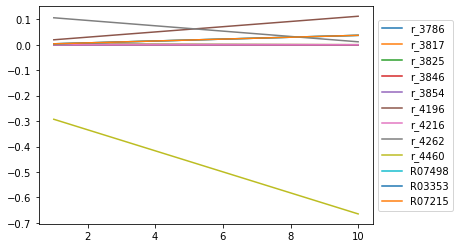

In [13]:
from matplotlib import pyplot as plt
fseofresult.data_frame[140:].T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/FSEOF.png")
plt.show()

From the FSEOF analysis, we can see that reaction r_4460 is negative. This suggests that a decrease in this reaction is correlated with an increase in production of 7-dehydrocholersterol. This reaction is the phosphate transport in via proton symport, which suggests that phosphate limitation might be productive for the optimization of our cell factory. 

We can therefore try to knock out this reaction and see if it changes anything, but we can also try to remove some of the phosphate from the environment.

In [7]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope, add_envelope
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 

Normal growth conditions
Maximal growth rate:
0.08374770604149165
Maximal 7-dehydrocholrsterol production rate
0.04117342484804841

Without phosphate
Maximal growth rate:
0.08305457249515771
Maximal 7-dehydrocholrsterol production rate
0.04022460002962988


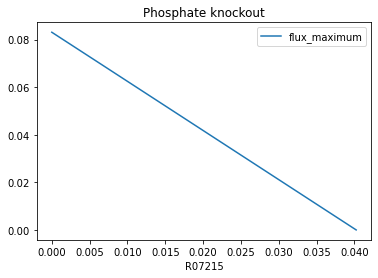

In [14]:
# Phosphate transport knockout
with model:    
    print("Normal growth conditions")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholrsterol production rate")
    print(model.slim_optimize())

with model:
    model.reactions.r_4460.knock_out()
    
    
    print("\nWithout phosphate")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholrsterol production rate")
    print(model.slim_optimize())
    
    ppp_7DH = production_envelope(model,
                    reactions=[model.reactions.R07215],
                    objective=model.reactions.r_2111)
    pppp = ppp_7DH.plot(x='R07215', y='flux_maximum')
    fig = pppp.get_figure()
    plt.title(label="Phosphate knockout")
    fig.savefig("figures/phospate_knockout_ppp")

Normal growth conditions
Maximal growth rate:
0.0837477866499979
Maximal 7-dehydrocholrsterol production rate
0.041173424848048625

Without phosphate
Maximal growth rate:
0.08313511104133789
Maximal 7-dehydrocholrsterol production rate
0.01666666666666649


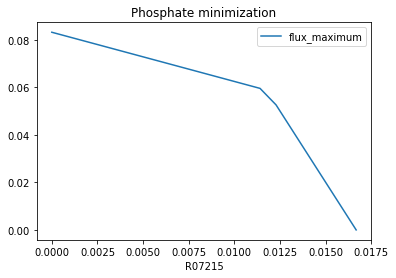

In [15]:
# Phosphate limitation in the media

with model:    
    print("Normal growth conditions")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholrsterol production rate")
    print(model.slim_optimize())

with model:
    medium = model.medium
    medium['r_2005'] = 0.1    
    model.medium = medium
    
    
    print("\nWithout phosphate")
    print("Maximal growth rate:")
    print(model.slim_optimize())
    model.objective = model.reactions.R07215
    print("Maximal 7-dehydrocholrsterol production rate")
    print(model.slim_optimize())
    
    ppp_7DH = production_envelope(model,
                    reactions=[model.reactions.R07215],
                    objective=model.reactions.r_2111)
    pppp = ppp_7DH.plot(x='R07215', y='flux_maximum')
    fig = pppp.get_figure()
    plt.title(label="Phosphate minimization")
    fig.savefig("figures/phosphate_minimization_ppp")

From this PPP, we can see our first deviation from the straight line that signals the trade-off between growth and production. We have now a better chance of finding an optimization route

In [4]:
from cameo.strain_design import OptGene

with model:
    medium = model.medium
    medium['r_2005'] =1    
    model.medium = medium
    with model:
        optgene = OptGene(model)
        result_phoslim1 = optgene.run(target=model.reactions.R07215,biomass=model.reactions.r_2111,substrate=model.reactions.r_1714,max_evaluations=2000,plot=False)

Starting optimization at Sun, 29 Nov 2020 21:18:22


HBox()

Finished after 01:09:23


In [5]:
result_phoslim1

,reactions,genes,size,fva_min,fva_max,target_flux,biomass_flux,yield,fitness
